In [123]:
import gym # 카트폴 등 여러 게임 환경을 제공하는 패키지입니다.
import random # 에이전트가 무작위로 행동할 확률을 구하기 위해 사용하는 파이썬 기본 패키지입니다.
import math # 에이전트가 무작위로 행동할 확률을 구하기 위해 사용하는 파이썬 기본 패키지입니다.
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque 
# deque : 선입선출(FIFO) 자료구조의 일종입니다. double-ended queue의 약자로 양쪽 끝에서 삽입과 삭제가 모두 가능합니다.
import matplotlib.pyplot as plt

In [124]:
# 하이퍼파라미터
EPISODES = 50    # 애피소드 반복횟수
EPS_START = 0.9  # 학습 시작시 에이전트가 무작위로 행동할 확률
EPS_END = 0.05   # 학습 막바지에 에이전트가 무작위로 행동할 확률
EPS_DECAY = 200  # 학습 진행시 에이전트가 무작위로 행동할 확률을 감소시키는 값
GAMMA = 0.8      # 할인계수
LR = 0.001       # 학습률
BATCH_SIZE = 64  # 배치 크기

In [125]:
class DQNAgent:
    def __init__(self):
        self.model = nn.Sequential(
            nn.Linear(4, 256), # 카트 위치, 카트 속도, 막대기 각도, 막대기 속도 4가지 정보를 받습니다(입력노드 4개)
            nn.ReLU(),
            nn.Linear(256, 2) # 왼쪽 or 오른쪽으로 출력합니다(출력노드 2개)
        )
        self.optimizer = optim.Adam(self.model.parameters(), LR) # Adam을 사용해 최적화합니다
        self.steps_done = 0 # 학습을 반복할 때마다 증가하는 변수입니다
        self.memory = deque(maxlen=10000) 
        # queue 자료구조를 이용합니다. deque의 maxlen을 지정하면 큐가 가득찼을 때 오래된 요소부터 없어집니다.

    def memorize(self, state, action, reward, next_state): 
        # memorize(self,현재상태, 현재 상태에서 한 행동, 행동에 대한 보상, 행동으로 인해 새로 생성된 상태):
        self.memory.append((state,
                            action,
                            torch.FloatTensor([reward]),
                            torch.FloatTensor([next_state])))
    
    def act(self, state):
        # 초반에는 엡실론 값을 높게하여 최대한 다양한 경험을 해보도록 하고, 점점 그 값을 낮춰가며 신경망이 결정하는 비율을 높임
        # 엡실론 그리디(혹은 엡실론 탐욕) 알고리즘 ( epsilon-greedy )
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if random.random() > eps_threshold:
            return self.model(state).data.max(1)[1].view(1, 1)
        else:
            return torch.LongTensor([[random.randrange(2)]])
    
    def learn(self): # 에이전트가 경험 리플레이를 하며 학습하는 역할을 수행합니다
        if len(self.memory) < BATCH_SIZE:
            return
        batch = random.sample(self.memory, BATCH_SIZE)
        states, actions, rewards, next_states = zip(*batch) # 4개의 배열로 정리해줍니다

        states = torch.cat(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)
        next_states = torch.cat(next_states) # 리스트 형태를 torch.cat() 함수로 하나의 텐서로 만듭니다

        current_q = self.model(states).gather(1, actions) 
        # gather()로 에이전트가 현 상태에서 했던 행동들의 가치를 current_q에 담습니다.
        max_next_q = self.model(next_states).detach().max(1)[0]
        expected_q = rewards + (GAMMA * max_next_q) # rewards + 미래가치 => 할인된 미래 가치가 expected_q에 담깁니다.
        
        loss = F.mse_loss(current_q.squeeze(), expected_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [126]:
env = gym.make('CartPole-v0') # gym으로 게임환경 생성 
agent = DQNAgent()
score_history = []

In [127]:
for e in range(1, EPISODES+1):
    state = env.reset() # 게임을 시작할 때마다 게임환경의 상태를 초기화합니다
    steps = 0
    while True:
        env.render()
        state = torch.FloatTensor(list(state)[0])
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action.item())[0]

        # 게임이 끝났을 경우 마이너스 보상주기
        if done:
            reward = -1

        agent.memorize(state, action, reward, next_state)
        agent.learn()

        state = next_state
        steps += 1

        if done:
            print("에피소드:{0} 점수: {1}".format(e, steps))
            score_history.append(steps)
            break

에피소드:1 점수: 1
에피소드:2 점수: 1
에피소드:3 점수: 1
에피소드:4 점수: 1
에피소드:5 점수: 1


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

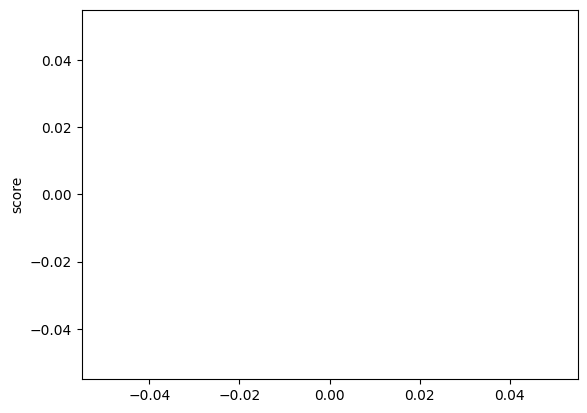

In [ ]:
plt.plot(score_history)
plt.ylabel('score')
plt.show()